## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.0 MB/s 
     |████████████████████████████████| 212 kB 87.4 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset = nlp.load_dataset("emotion")

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets,labels

In [ ]:
tweets,labels = get_tweet(train)

In [ ]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
# tensorflow has a built in tokenizer

In [ ]:
# tokenizer converts every word in the tweets into numbers ( each unique word  gets a each unique token)
tokenizer = Tokenizer(num_words= 10000, oov_token = '<UNK') #most frequently used 10000 words in our data, UNK for not frequently used, UNK has a coresponding numeric value too
tokenizer.fit_on_texts(tweets) # tokenizing our tweets data


In [ ]:
tokenizer.texts_to_sequences([tweets[10]]), tokenizer.texts_to_sequences([labels[10]])

([[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]], [[953]])

In [ ]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something',
 'sadness')

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

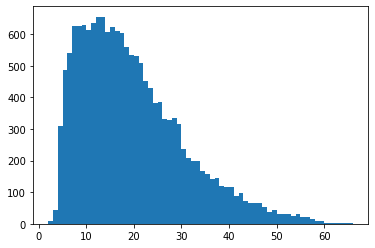

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [ ]:
# truncating the data with length of tweet greater than a threshold
maxlen = 50
# padding the lenghts less than max_length to zero
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences (tookenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_seq[100]

array([   2,  445,  207,   18,  379,  632,   13,   50,   37,    2,    3,
          9,  347,   68,    4, 4174,   34,   98,   20,   56,   20,   87,
          5,   28, 2746,    9,  118, 5291,   16,  143,  905,  192,  350,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
 tweets[100], labels[100]

('i wont let me child cry it out because i feel that loving her and lily when she was little was going to be opportunities that only lasted for those short few months',
 'love')

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels) # shows all the 6 emotions tied up with the dataset
print(classes)

{'fear', 'anger', 'sadness', 'surprise', 'joy', 'love'}


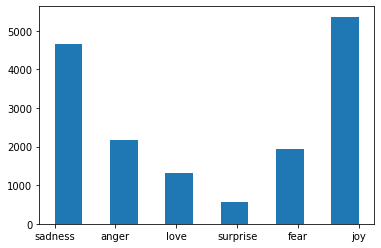

In [ ]:
plt.hist(labels,bins=11)
plt.show()

In [ ]:
# converting the emotions(classes) to numeric values
class_to_index = dict((c,i) for i,c in enumerate(classes)) # c- class name, i - numeric value for that class
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [ ]:
class_to_index

{'fear': 0, 'anger': 1, 'sadness': 2, 'surprise': 3, 'joy': 4, 'love': 5}

In [ ]:
index_to_class

{0: 'fear', 1: 'anger', 2: 'sadness', 3: 'surprise', 4: 'joy', 5: 'love'}

In [ ]:
names_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[100])

5


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential(
    [
     tf.keras.layers.Embedding(10000,16,input_length = maxlen), #Embedded layer
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences = True)), #LSTM layer
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
     tf.keras.layers.Dense(6, activation = 'softmax')
    ]
)

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics =['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs =20,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=2)]
)

Epoch 1/20
500/500 [==============================] - 16s 15ms/step - loss: 1.3010 - accuracy: 0.4884 - val_loss: 0.7918 - val_accuracy: 0.7005
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.6277 - accuracy: 0.7439 - val_loss: 0.6645 - val_accuracy: 0.7410
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.4492 - accuracy: 0.8160 - val_loss: 0.5605 - val_accuracy: 0.8180
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3081 - accuracy: 0.8982 - val_loss: 0.4752 - val_accuracy: 0.8490
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2013 - accuracy: 0.9351 - val_loss: 0.4362 - val_accuracy: 0.8705
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1329 - accuracy: 0.9582 - val_loss: 0.4110 - val_accuracy: 0.8825
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1018 - accuracy: 0.9672 - val_loss: 0.4410 - val_accuracy: 0.872

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

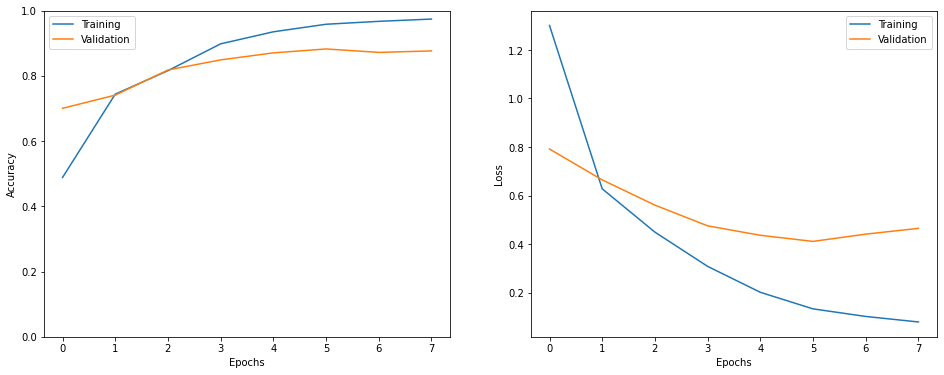

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets )
test_labels = names_to_ids(test_labels)


In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4468 - accuracy: 0.8685


In [ ]:
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: ive been too deep down in the swamps swimming in muddy waters tortured by fear feeling lonely and lost
Emotion: sadness
Predicted Emotion: anger


In [ ]:
preds = model.predict(test_seq)


In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))

ValueError: ignored